# _Examinationsarbete i Deep Learning_

**Project $alpha$**

Målbild:

- Designa och träna Convolutional Neural Networks (CNNs) från grunden, för att klassificera bilder i CIFAR-10 datasetet.

Generella och specifika kraven för betygsgränser beskrivs längre ner.

---


## _Dataset, CIFAR-10_


- **Antal bilder:** 60,000 (32x32 pixlar, färgbilder).
- **Klasser:** 10 klasser (t.ex. flygplan, bil, fågel, katt).
- **Uppdelning:**
  - Träning: 50,000 bilder.
  - Test: 10,000 bilder.

**Evalueringskrav**

Datasetet ska laddas in från PyTorchs `torchvision` bibliotek, och tillhörande testset ska användas för evaluering.


---

**Project $alpha$**

Här ska ni designa och träna Convolutional Neural Networks (CNNs) från grunden, i syfte att klassificera bilder i CIFAR-10-datasetet.

**Krav för G:**

- Mellan **75-80% accuracy** på test-settet.
- Designa, träna och evaluera minst **tre olika CNN-arkitekturer**.
- Prestandan av varje färdigtränad modell ska vara tydlig, och även loss-kurvor ska plottas - följt av en kortfattad analys av dessa.
- I varje CNN-klass ska, i `forward`-metoden, **storleken på input och output för varje operation** skrivas ut som en kommentar.
- Gör dessutom en **kvalitativ analys** av dina modellers prestanda (vilka klasser presteras bra på, och vilka dåligt) - och varför, om möjligt.

**Krav för VG:**

- Uppnår kraven för **G**, och når **85%+ accuracy** på test-settet.
- Ni använder dessutom flertalet metoder under träningen som ni själva läst på och lärt er om, exempelvis via litteraturhänvisningen.
  - samtliga metoder, utöver de vi gått igenom i klassen, som ni väljer att använda ska ni i ett särskilt stycke i er notebook, förklara (så gott ni kan)
    samt ge referenser till.
- Ni ska även att utföra en ordentlig error analysis, på er bäst presterade modell.

**Krav för Guldstjärna:**

- Uppnår kraven för **VG**, och når **90%+ accuracy** på test-settet.


Var kreativa med era arkitekturer. Ni behöver exempelvis inte begränsa er till det 'normala' convolutional block som vi
lärde oss under föreläsningarna (dvs conv layer + relu följt av pooling), utan det kan se annorlunda ut. Se litteraturhänvisningarna för inspiration från kända CNN-arkitekturer som ex. AlexNet, VGG, ResNet etc.

Utöver det finns det andra knep man kan integrera in i sin CNN som empiriskt visat förbättra prestanda. Exempelvis:

- Batch Normalization
- Data Augmentation
- Alternativa Optimizers (ex Adam, RMSprop)
- Learning Rate Scheduling

Ni har friheten att själva söka information om dessa och hur de implementeras i PyTorch, för att sedan nyttja dem i ert projekt.


**Pre-trained models & Transfer Learning**

Kraven för alla betyg (och Guldstjärnan) går att uppnå med att träna modeller från grunden, men ni får givetvis även försöka er på att använda en pre-trained model om ni vill. Men, ni får inte **enbart** använda pre-trained models (max antal: 1).

Det kan dock vara rätt beräkningstungt.


---

**Inlämning**


Ni lämnar in en notebook fil som innehåller allt arbete. Notebooken ska dessutom sparas med alla outputen kvarstående!

Mao ska jag bara kunna bläddra igenom er notebook för att se allt arbete och alla output, utan att för den delen köra koden själv.

Spara notebook:en med namnet **{namn}\_{efternamn}\_{alpha}.ipynb**, och skicka därefter in via ITHS-portalen.


---

**Literaturlista**

Följande research ger både en inblick i historiken av CNN-arkitekturers utveckling, och kan ge idéer om nyttiga idéer i era egna projekt:

- [**LeNet-5**](http://yann.lecun.com/exdb/lenet/). Grundläggande arbete som introducer konceptet med Convolutional Neural Networks.
- [**AlexNet**](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf). Vann ImageNet-tävlingen 2012, genom att bland annat introducera "ReLU".
- [**VGGNet**](https://arxiv.org/abs/1409.1556).
- [**GoogLeNet**](https://arxiv.org/abs/1409.4842). Introducerade "Inception"-modulen (aka "bottle-neck layer").
- [**ResNet**](http://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf). Introducerar "skip connections" som hjälper djupa nätverk att lära sig.
- [**EfficientNet**](https://arxiv.org/abs/1905.11946)

Ni kan givetvis lära er mer om dessa koncept genom att söka efter alternativa källor också.


---

## Imports


In [140]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib.pyplot import imshow

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.optim import Adam,RMSprop
from torch.utils.data import DataLoader
import torchvision.models as models
from torch.optim.lr_scheduler import StepLR

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report

import random
from matplotlib import pyplot as plt

import warnings

warnings.filterwarnings('ignore')

---

## Define data variables


In [145]:
def get_mean_std(loader):
    # Compute the mean and standard deviation of all pixels in the dataset
    num_pixels = 0
    mean = 0.0
    std = 0.0

    for images, _ in loader:
        # Rearrange images to be the shape of [B, C, W * H]
        images = images.view(images.size(0), images.size(1), -1)
        # Update total number of images
        num_pixels += images.size(0)
        # Compute mean and std here
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)

    mean /= num_pixels
    std /= num_pixels

    return mean, std

In [148]:
trainset0 = torchvision.datasets.CIFAR10(
    root='./data/', train=True, download=False, transform=transforms.ToTensor())

In [149]:
trainloader0 = torch.utils.data.DataLoader(
    trainset0, batch_size=64, shuffle=True)
mean, std = get_mean_std(trainloader0)

print(mean)
print(std)

tensor([0.4914, 0.4822, 0.4465])
tensor([0.2023, 0.1994, 0.2010])


In [ ]:
train_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.4918, 0.4825, 0.4470), (0.2023, 0.1995, 0.2011))])
transforms.RandAugment(15)
transforms.RandomRotation
# Normalization transform
test_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.4918, 0.4825, 0.4470), (0.2023, 0.1995, 0.2011))])

# Load training and test datasets with normalization
trainset = torchvision.datasets.CIFAR10(
    root='./data/', train=True, download=False, transform=train_transform)
testset = torchvision.datasets.CIFAR10(
    root='./data/', train=False, download=False, transform=test_transform)

100%|██████████| 170M/170M [00:10<00:00, 16.7MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified


In [40]:
__, height, width, channels = testset.data.shape
class_names = testset.classes
classes = len(class_names)

In [151]:
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


---

# Define DataLoaders


In [153]:
train_dataloader = DataLoader(trainset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=32, shuffle=False)

In [154]:
print(len(train_dataloader))
print(len(test_dataloader))

1563
313


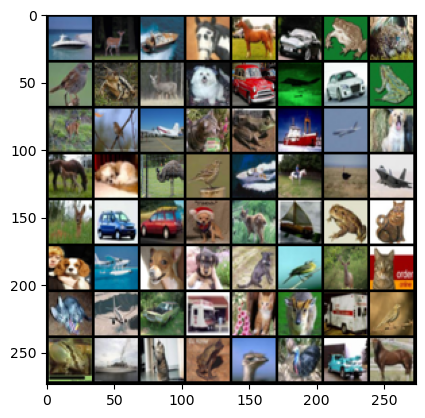

In [155]:

images, labels = next(iter(trainloader0))


def image_viz(img):
    image = img.numpy()
    image = np.transpose(image, (1, 2, 0))
    imshow(image)


fullgrid = torchvision.utils.make_grid(images)
image_viz(fullgrid)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


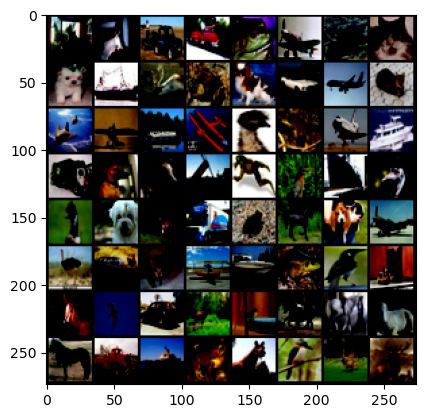

In [157]:
images, labels = next(iter(trainloader))
fullgrid = torchvision.utils.make_grid(images)
image_viz(fullgrid)

---

# Initialize Models


## 1. CNN


### Arthicture


In [134]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = self.flat(x)
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

### init


In [133]:
cnn_model = CNNModel().to(device)
optimizer = RMSprop(cnn_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=10, gamma=0.8)

### train CNN


In [136]:
batch_train_losses = []
epoch_train_losses = []
epoch_evaluation_losses = []
epoch_evaluation_accuracies = []

EPOCHS = 50

for epoch in range(EPOCHS):
    # Training phase
    cnn_model.train()
    running_loss = 0

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    for input_features, y_true in tqdm(train_dataloader, desc="Training", leave=False):
        input_features, y_true = input_features.to(device), y_true.to(device)

        # Forward pass
        y_pred = cnn_model(input_features)
        loss = criterion(y_pred, y_true)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record batch loss
        batch_loss = loss.item()
        running_loss += batch_loss
        batch_train_losses.append(batch_loss)

    # Average training loss
    epoch_average_loss = running_loss / len(train_dataloader)
    epoch_train_losses.append(epoch_average_loss)

    # Step the scheduler
    scheduler.step()

    # Evaluation phase
    cnn_model.eval()
    evaluation_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for input_features, y_true in tqdm(test_dataloader, desc="Evaluating", leave=False):
            input_features, y_true = input_features.to(device), y_true.to(device)

            # Forward pass
            y_pred = cnn_model(input_features)
            loss = criterion(y_pred, y_true)
            evaluation_loss += loss.item()

            # Accuracy calculation
            _, predicted_class = torch.max(y_pred, dim=1)
            correct_predictions += (predicted_class == y_true).sum().item()
            total_predictions += y_true.size(0)

    # Record evaluation metrics
    epoch_evaluation_losses.append(evaluation_loss / len(test_dataloader))
    accuracy = correct_predictions / total_predictions
    epoch_evaluation_accuracies.append(accuracy)

    # Print epoch metrics
    print(
        f"Epoch {epoch + 1}/{EPOCHS}: "
        f"Train Loss = {epoch_average_loss:.4f}, "
        f"Test Loss = {epoch_evaluation_losses[-1]:.4f}, "
        f"Test Accuracy = {accuracy:.4f}, "
        f"Learning Rate = {scheduler.get_last_lr()[0]:.6f}"
    )

# Plot train and test losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), epoch_train_losses, label="Train Loss", marker="o")
plt.plot(range(1, EPOCHS + 1), epoch_evaluation_losses, label="Test Loss", marker="o", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Test Loss per Epoch")
plt.legend()
plt.grid()
plt.show()

# Plot test accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), epoch_evaluation_accuracies, label="Test Accuracy", marker="o", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Test Accuracy per Epoch")
plt.legend()
plt.grid()
plt.show()


Epoch 1/50


Epoch 1/50: Train Loss = 2.0553, Test Loss = 1.7789, Test Accuracy = 0.3417, Learning Rate = 0.010000
Epoch 2/50


Epoch 2/50: Train Loss = 1.9262, Test Loss = 1.7492, Test Accuracy = 0.3711, Learning Rate = 0.010000
Epoch 3/50


Epoch 3/50: Train Loss = 1.6534, Test Loss = 1.5842, Test Accuracy = 0.4312, Learning Rate = 0.010000
Epoch 4/50


Epoch 4/50: Train Loss = 1.4885, Test Loss = 1.5560, Test Accuracy = 0.4666, Learning Rate = 0.010000
Epoch 5/50


Epoch 5/50: Train Loss = 1.3588, Test Loss = 1.5014, Test Accuracy = 0.4852, Learning Rate = 0.010000
Epoch 6/50


Epoch 6/50: Train Loss = 1.2808, Test Loss = 1.5018, Test Accuracy = 0.5120, Learning Rate = 0.010000
Epoch 7/50


Epoch 7/50: Train Loss = 1.2327, Test Loss = 1.5625, Test Accuracy = 0.5167, Learning Rate = 0.010000
Epoch 8/50


Epoch 8/50: Train Loss = 1.2289, Test Loss = 1.5897, Test Accuracy = 0.4832, Learning Rate = 0.010000
Epoch 9/50


Epoch 9/50: Train Loss = 1.1643, Test Loss = 1.3850, Test Accuracy = 0.5388, Learning Rate = 0.010000
Epoch 10/50


Epoch 10/50: Train Loss = 1.1539, Test Loss = 1.3049, Test Accuracy = 0.5861, Learning Rate = 0.008000
Epoch 11/50


Epoch 11/50: Train Loss = 1.0395, Test Loss = 1.3761, Test Accuracy = 0.5718, Learning Rate = 0.008000
Epoch 12/50


Epoch 12/50: Train Loss = 1.0353, Test Loss = 1.5299, Test Accuracy = 0.5319, Learning Rate = 0.008000
Epoch 13/50


Epoch 13/50: Train Loss = 0.9834, Test Loss = 1.6567, Test Accuracy = 0.5248, Learning Rate = 0.008000
Epoch 14/50


Epoch 14/50: Train Loss = 0.9812, Test Loss = 1.3045, Test Accuracy = 0.6044, Learning Rate = 0.008000
Epoch 15/50


Epoch 15/50: Train Loss = 0.9882, Test Loss = 1.5966, Test Accuracy = 0.5218, Learning Rate = 0.008000
Epoch 16/50


Epoch 16/50: Train Loss = 0.9475, Test Loss = 1.2954, Test Accuracy = 0.5856, Learning Rate = 0.008000
Epoch 17/50


Epoch 17/50: Train Loss = 0.9316, Test Loss = 1.4111, Test Accuracy = 0.5957, Learning Rate = 0.008000
Epoch 18/50


Epoch 18/50: Train Loss = 0.9204, Test Loss = 1.4974, Test Accuracy = 0.5865, Learning Rate = 0.008000
Epoch 19/50


Epoch 19/50: Train Loss = 0.9283, Test Loss = 1.6265, Test Accuracy = 0.4881, Learning Rate = 0.008000
Epoch 20/50


Epoch 20/50: Train Loss = 0.8957, Test Loss = 1.3389, Test Accuracy = 0.6084, Learning Rate = 0.006400
Epoch 21/50


Epoch 21/50: Train Loss = 0.8160, Test Loss = 1.3730, Test Accuracy = 0.5993, Learning Rate = 0.006400
Epoch 22/50


Epoch 22/50: Train Loss = 0.7858, Test Loss = 1.4045, Test Accuracy = 0.5990, Learning Rate = 0.006400
Epoch 23/50


Epoch 23/50: Train Loss = 0.7780, Test Loss = 1.3608, Test Accuracy = 0.5991, Learning Rate = 0.006400
Epoch 24/50


Epoch 24/50: Train Loss = 0.7666, Test Loss = 1.3777, Test Accuracy = 0.6164, Learning Rate = 0.006400
Epoch 25/50


Epoch 25/50: Train Loss = 0.7571, Test Loss = 1.4390, Test Accuracy = 0.6256, Learning Rate = 0.006400
Epoch 26/50


Epoch 26/50: Train Loss = 0.7474, Test Loss = 1.8153, Test Accuracy = 0.5633, Learning Rate = 0.006400
Epoch 27/50


Epoch 27/50: Train Loss = 0.7368, Test Loss = 1.4081, Test Accuracy = 0.6164, Learning Rate = 0.006400
Epoch 28/50


Epoch 28/50: Train Loss = 0.7490, Test Loss = 1.5380, Test Accuracy = 0.6041, Learning Rate = 0.006400
Epoch 29/50


Epoch 29/50: Train Loss = 0.7212, Test Loss = 1.7143, Test Accuracy = 0.5660, Learning Rate = 0.006400
Epoch 30/50


Epoch 30/50: Train Loss = 0.7455, Test Loss = 1.4488, Test Accuracy = 0.6262, Learning Rate = 0.005120
Epoch 31/50


Epoch 31/50: Train Loss = 0.6366, Test Loss = 1.5396, Test Accuracy = 0.6165, Learning Rate = 0.005120
Epoch 32/50


Epoch 32/50: Train Loss = 0.6302, Test Loss = 1.7122, Test Accuracy = 0.5784, Learning Rate = 0.005120
Epoch 33/50


Epoch 33/50: Train Loss = 0.6178, Test Loss = 1.6910, Test Accuracy = 0.5983, Learning Rate = 0.005120
Epoch 34/50


Epoch 34/50: Train Loss = 0.6057, Test Loss = 2.0398, Test Accuracy = 0.5951, Learning Rate = 0.005120
Epoch 35/50


Epoch 35/50: Train Loss = 0.5951, Test Loss = 1.9838, Test Accuracy = 0.6136, Learning Rate = 0.005120
Epoch 36/50


Epoch 36/50: Train Loss = 0.6067, Test Loss = 1.7799, Test Accuracy = 0.5926, Learning Rate = 0.005120
Epoch 37/50


Epoch 37/50: Train Loss = 0.5905, Test Loss = 1.8587, Test Accuracy = 0.5959, Learning Rate = 0.005120
Epoch 38/50


Epoch 38/50: Train Loss = 0.5745, Test Loss = 1.8089, Test Accuracy = 0.6079, Learning Rate = 0.005120
Epoch 39/50


Epoch 39/50: Train Loss = 0.5812, Test Loss = 2.1608, Test Accuracy = 0.6042, Learning Rate = 0.005120
Epoch 40/50


Epoch 40/50: Train Loss = 0.5765, Test Loss = 1.9973, Test Accuracy = 0.6119, Learning Rate = 0.004096
Epoch 41/50


Epoch 41/50: Train Loss = 0.5257, Test Loss = 1.9552, Test Accuracy = 0.6105, Learning Rate = 0.004096
Epoch 42/50


Epoch 42/50: Train Loss = 0.5086, Test Loss = 1.9371, Test Accuracy = 0.6030, Learning Rate = 0.004096
Epoch 43/50


KeyboardInterrupt: 

## 2. CNN


## 3. ResNet18


In [87]:
ResNet18_model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\HP/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 35.2MB/s]


In [93]:
ResNet18_model.conv1 = nn.Conv2d(
    channels, 64, kernel_size=3, stride=1, padding=1, bias=False)

In [94]:
ResNet18_model.maxpool = nn.Identity()
num_features = ResNet18_model.fc.in_features
ResNet18_model.fc = nn.Linear(num_features,classes)

In [98]:
optimizer = Adam(ResNet18_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [99]:
batch_train_losses = []
epoch_train_losses = []
epoch_evaluation_losses = []
epoch_evaluation_accuracies = []

EPOCHS = 10

for epoch in range(EPOCHS):
    ResNet18_model.train()
    running_loss = 0

    for batch in train_dataloader:
        input_features, y_true = batch
        input_features, y_true = input_features.to(device), y_true.to(device)

        # Forward pass
        y_pred = ResNet18_model(input_features)
        loss = criterion(y_pred, y_true)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss = loss.item()
        running_loss += batch_loss
        batch_train_losses.append(batch_loss)

    # Calculate average loss for the epoch
    epoch_average_loss = running_loss / len(train_dataloader)
    epoch_train_losses.append(epoch_average_loss)

    # Evaluation section
    ResNet18_model.eval()
    evaluation_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for input_features, y_true in test_dataloader:
            input_features, y_true = input_features.to(
                device), y_true.to(device)

            # Forward pass
            y_pred = ResNet18_model(input_features)
            loss = criterion(y_pred, y_true)
            evaluation_loss += loss.item()

            # Accuracy calculation
            _, predicted_class = torch.max(y_pred, dim=1)
            correct_predictions += (predicted_class == y_true).sum().item()
            total_predictions += y_true.size(0)

    # Record evaluation metrics
    epoch_evaluation_losses.append(evaluation_loss / len(test_dataloader))
    accuracy = correct_predictions / total_predictions
    epoch_evaluation_accuracies.append(accuracy)

    # Print epoch metrics
    print(
        f"Epoch {epoch + 1}/{EPOCHS}: "
        f"Train Loss = {epoch_average_loss:.4f}, "
        f"Test Loss = {epoch_evaluation_losses[-1]:.4f}, "
        f"Test Accuracy = {accuracy:.4f}"
    )

# Print summary of results
print("\nTraining Summary:")
for epoch in range(EPOCHS):
    print(
        f"Epoch {epoch + 1}: "
        f"Train Loss = {epoch_train_losses[epoch]:.4f}, "
        f"Test Loss = {epoch_evaluation_losses[epoch]:.4f}, "
        f"Test Accuracy = {epoch_evaluation_accuracies[epoch]:.4f}"
    )

KeyboardInterrupt: 

---


In [41]:
import matplotlib.pyplot as plt
import random
import torch


def show_random_samples(dataset, num_samples=5, class_names=None):
    """
    Displays random samples from the dataset with their labels.

    Args:
        dataset: A PyTorch Dataset.
        num_samples: Number of random samples to display.
        class_names: A list of class names for labels (optional).
    """
    indices = random.sample(range(len(dataset)), num_samples)  # Random indices
    plt.figure(figsize=(15, 5))  # Adjust figure size based on num_samples

    for i, idx in enumerate(indices):
        # Get image and label
        image, label = dataset[idx]

        # Handle image dimensions
        if image.shape[0] == 1:  # Grayscale image (C, H, W -> H, W)
            image = image.squeeze(0)
            plt.imshow(image, cmap="gray")  # Grayscale images
        elif image.shape[0] == 3:  # RGB image (C, H, W -> H, W, C)
            image = image.permute(1, 2, 0)  # Transpose to H, W, C
            plt.imshow(image)  # RGB images
        else:
            raise ValueError(f"Unexpected image shape: {image.shape}")

        # Display the image
        plt.subplot(1, num_samples, i + 1)
        plt.axis("off")  # Remove axes
        if class_names:
            plt.title(f"{class_names[label]}")
        else:
            plt.title(f"Label: {label}")

    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


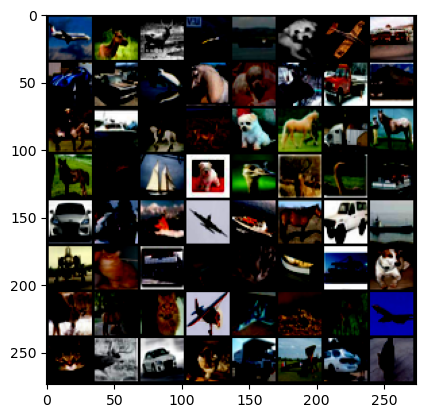

In [141]:

images, labels = next(iter(trainloader))


def image_viz(img):
    image = img.numpy()
    image = np.transpose(image, (1, 2, 0))
    imshow(image)


fullgrid = torchvision.utils.make_grid(images)
image_viz(fullgrid)